<a target="_blank" href="https://colab.research.google.com/github/sonder-art/automl_o23/blob/main/codigo/intro_redes_neuronales/entrenamiento_de_redes_neuronales.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

Librerias

In [5]:
#Import Libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable

import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

# MNIST

## Lectura de datos




In [6]:
# Diccionarios de argumentos
args={}
kwargs={}

# Tamano de lote o Batch
args['batch_size']=1000
args['test_batch_size']=1000

# Hyperparametros de Entrenamiento
# Epoca:= El numero de veces por el que pasamos por todos los datos
args['epoch']=10  
# La tasa de aprendizaje del descenso por gradiente 
args['lr']=0.01 
# El momento o momentum del descenso por gradiente
args['momentum']=0.5 

# Parametros de Pytorch
# Semilla aleatoria
args['seed']=345 
args['log_interval']=10
# Usar GPU si existe (cuda), de lo contrario cpu.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()
args['cuda']= device.type


Using device: cuda



El siguiente bloque carga los datos, y los divide en entrenamiento y prueba. 


```
torch.utils.data.DataLoader
```
https://pytorch.org/docs/stable/data.html  
Es el metodo que nos permite cargar los datos y preparlos para el entrenamiento y validacion.  
En este caso recibe 3 argumentos.
+ **datasets.MNIST**:= Indica que datos queremos, en este caso MNIST.
+ **batch_size**:= el tamano del lote o del batch de entrenamiento.
+ **shuffle**:= Si queremos barajear nuestro dataset cada epoca.



```
datasets.MNIST
```
https://pytorch.org/docs/stable/torchvision/datasets.html#mnist 
Es el metodo que llama a los datos del MNIST en particular.  
En este caso recibe 4 argumentos
+ **root**:= Directorio donde existe o descargaran las imagenes o datos.
+ **train**:= Si utiliza los datos de entrenamiento o no.
+ **download**:= Si descarga los datos o no. Si los datos ya estan en le directorio especificado por root no descarga.
+ **transform**:= Si aplica transformaciones a las imagenes.



```
transforms.Compose
```
https://pytorch.org/docs/stable/torchvision/transforms.html  
Esta funcion nos permite anidar transformaciones, parecido al metodo sequential que usamos apra construir redes, pero aplicado a transformaciones.  
En este caso pasamos 2 transformaciones:
+ **transform.ToTensor**:= Convierte las imagenes a un tensor, que es el tipo de estructura de datos que utiliza pytorch.
+ **transform.Normalize**:= Normaliza los tensores. Debemos aplicar la misma normalizacion a los datos de entrenamiento que a los de prueba.
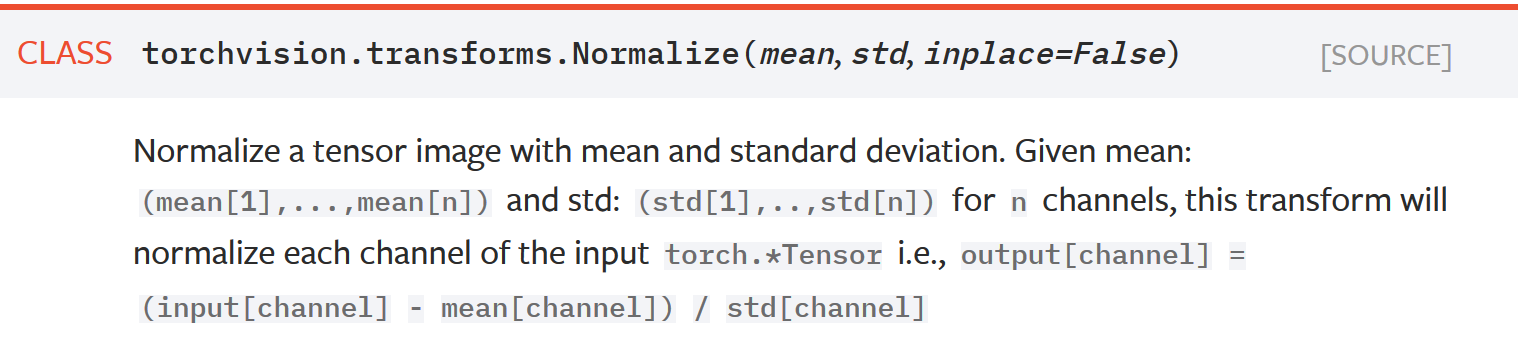






In [7]:
#load the data
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST(root='../data', 
                   train=True, 
                   download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor()
                       #transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=args['batch_size'], 
    shuffle=True)


100.0%


Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw


100.0%


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw




17.9%

100.0%


Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw



100.0%

Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



+ Media y desviacion estandard de un solo lote o batch. 
+ Graficar una observacion

Dimension del batch (numero de obs en el batch, canales, altura, ancho)
 torch.Size([1000, 1, 28, 28])

Media del batch:   tensor(0.1307)
Std del batch:   tensor(0.3080)
Contenido de una observacion en formato tensorial 
 tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.00

([], [])

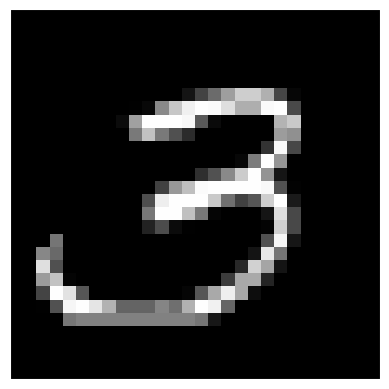

In [9]:
examples = enumerate(train_loader)
batch_idx, (example_data, example_targets) = next(examples)

print('Dimension del batch (numero de obs en el batch, canales, altura, ancho)\n'
 ,example_data.shape)
print('\nMedia del batch:  ', torch.mean(example_data))
print('Std del batch:  ', torch.std(example_data))
print('Contenido de una observacion en formato tensorial \n', example_data[0][0])

fig = plt.figure()
plt.tight_layout()
plt.imshow(example_data[0][0], cmap='gray', interpolation='none')
plt.xticks([])
plt.yticks([])

Veamos la media y desviacion estandard de todos los batches de entrenamiento.

In [10]:
examples = enumerate(train_loader)

# Listas para guardar resultados por batch
batch_mean = []
batch_std = []
batch_labels = []

for batch_idx, (example_data, example_targets) in examples:
  batch_mean.append(torch.mean(example_data).item())
  batch_std.append(torch.std(example_data).item())
  batch_labels.append(example_targets)

# Convertir las etiquetas a numpy array
batch_labels = map(lambda x: x.numpy(), batch_labels )
batch_labels = np.concatenate(list(batch_labels))
batch_labels

array([9, 2, 6, ..., 1, 3, 5])

**Distribucion/balanceo de las etiquetas**

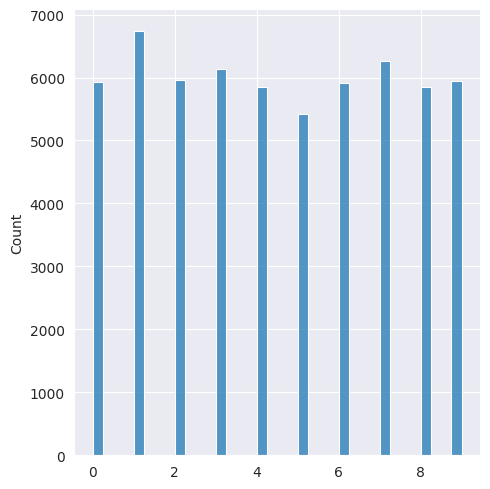

In [11]:
sns.displot(data=batch_labels)

**Histograma de la Media de pixeles**

Media de pixeles:   0.13066047926743826


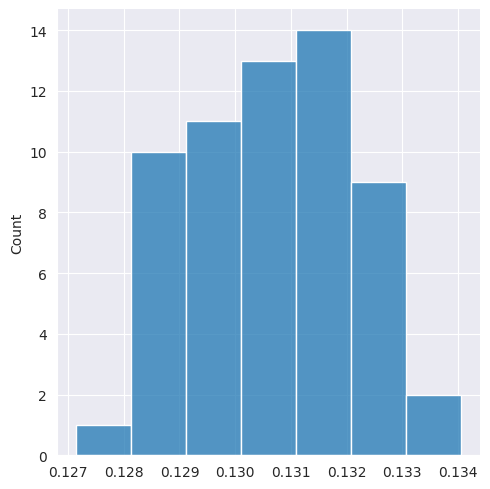

In [12]:
sns.displot(data=batch_mean)
print('Media de pixeles:  ',sum(batch_mean)/len(batch_mean))

**Histograma de la std de los pixeles**

Std de pixeles:   0.3080994640787443


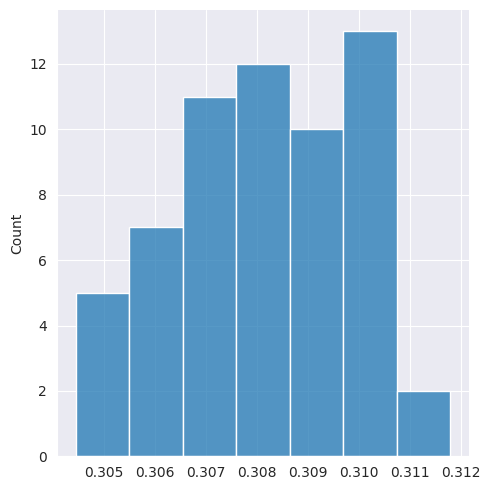

In [13]:
print('Std de pixeles:  ',sum(batch_std)/len(batch_std))
sns.displot(data=batch_std)

Vistazo a los datos de prueba, con y sin normalizacion. En este caso a simple vista no hay mucha diferencia, aun asi es importante normalizar!  
En esta ocasion como las imagenes son en blanco y negro, solo tenemos un canal.

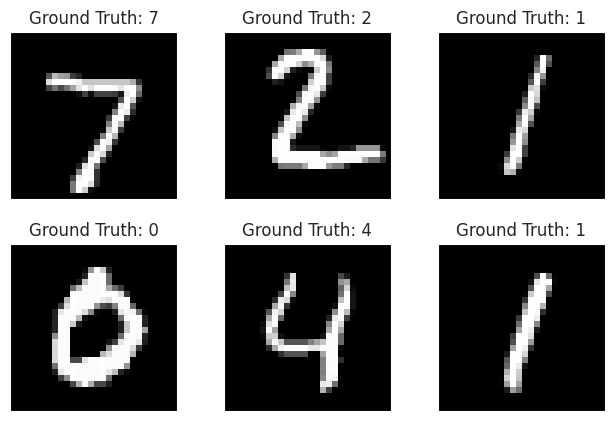

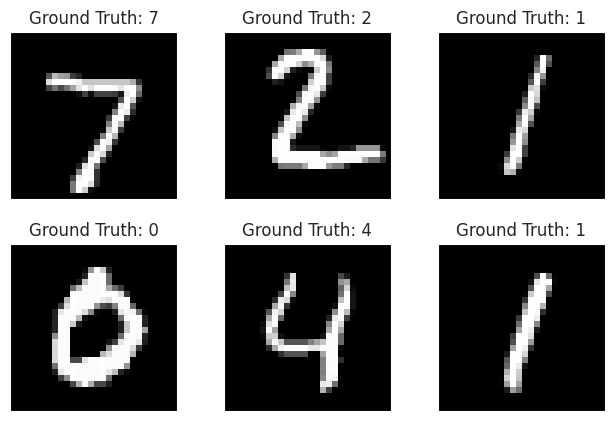

In [15]:

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                       transforms.ToTensor()
                       #transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=args['test_batch_size'], 
    shuffle=False)

examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

example_data.shape

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig

torch.Size([1000, 1, 28, 28])


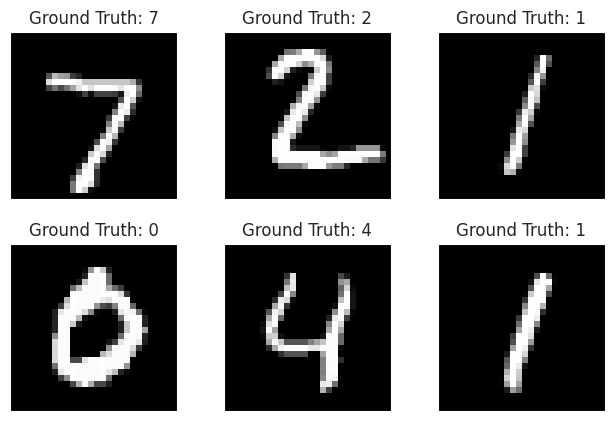

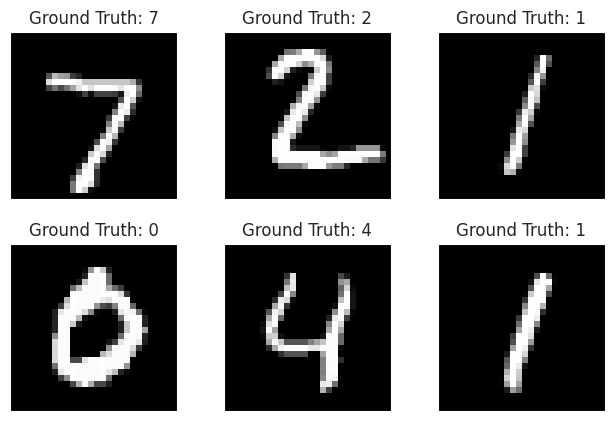

In [16]:
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=args['test_batch_size'], 
    shuffle=False)

examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

print(example_data.shape)


fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig

Carguemos los datos que utilizaremos, observa que argumentos cambian, respecto a los bloques anteriores.


In [17]:
#load the data
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST(root='../data', 
                   train=True, 
                   download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=args['batch_size'], 
    shuffle=True)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', 
                   train=False, 
                   download = True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=args['test_batch_size'], 
    shuffle=True)

### Resumen de lectura de datos

+ Hemos cargado los datos, y los hemos dividido entre entrenamiento y prueba.
+ Hemo visto la distribucion de las etiquetas (labels) en el entrenamiento, que parece bastante balanceada.
+ Hemos obtenido la media y std de los datos de entrenamiento.
+ Normalizamos los datos.
+ Revisamos la integridad de los datos.  
Hemos realizado con exito el ETL, y parte del EDA

## Definamos la Red Neuronal

Utilizemos el metodo de red neuronal que definimos la clase pasada.

In [18]:
from torch import nn

class RedNeuronal(nn.Module):

    def __init__(self, in_n=784, hidden_n=256, out_n=1):
        super(RedNeuronal, self).__init__()
        
        # W0:= Pesos entrada -> oculta 
        # nn.Linear(neuronas de entrada, neuronas ocultas, bias=True)
        self.hidden = nn.Linear(in_n, hidden_n)

        # W1:= Pesos oculta -> salida 
        # nn.Linear(neuronas ocultas, neuronas salida, bias=True)
        self.output = nn.Linear(hidden_n, out_n)
        
        # Funciones de Activacion 
        # Sigma 1 [capa oculta]
        self.sigmoid = nn.Sigmoid()
        # Sigma 2 [capa de salida]
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x):
        # Flujo o feedforward de nuestra red

        # Flatten tensores de imagenes
        x = x.view(x.size(0), -1)
        # Multiplicacion de X0 por W0
        x = self.hidden(x)
        # Evaluar Sigma uno / Obtener X1
        x = self.sigmoid(x)
        # Multiplicacion de X1 por W1
        x = self.output(x)
        # Evaluar en Sigma 2 / Obtener X2
        x = F.log_softmax(x, dim=1)
        return x

## Definamos la funcion para evaluar nuestro modelo

+ **model.eval**:= Pone al modelo en modo de evaluacion. No calcula el gradiente, y desactiva el comportamiento de entrenamiento. Por ejemplo, descativa el dropout de neuronas.
+ **.cuda()** = carga el tensor al GPU
+ **F.nll_loss**:= Funcion negative log-likelihood 
+ **output.data.max**:= Nos regresa el valor maximo del tensor, y el indice que le corresponde.

In [23]:
def prueba(model, test_loader, args):
    # Cambia el modelo a modo evaluacion, por ejemplo elimina el dropout
    model.eval()
    # Variables oara accumular en el loop
    test_loss = 0
    correct = 0

    # Iterar sobre los batches/lotes de prueba
    for data, target in test_loader:

        # Carga los tensores a GPU de ser necesario
        if args['cuda'] == 'cuda':
            data, target = data.cuda(), target.cuda()

        # Resultado del feedforward
        output = model(data)

        # Funcion de perdida en el batch, negative log-likelihood loss
        test_loss += F.nll_loss(output, target, reduction='sum').item()

        # Obtener la neurona -> label con mayor probabilidad
        # La neurona k corresponde al numero k o etiqueta k.
        pred = output.data.max(1, keepdim=True)[1] 

        # Numero de predicciones correctas, .cpu() copia los tensores al cpu
        correct += pred.eq(target.data.view_as(pred)).long().cpu().sum()
    
    # % de obsrvaciones correctas
    test_loss /= len(test_loader.dataset)
    print('\n Datos de Prueba: Perdida: {:.3f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [24]:
model_nn = RedNeuronal(in_n=784, hidden_n=256, out_n=10)
if args['cuda'] == 'cuda':
    model_nn.cuda()
prueba(model = model_nn, test_loader=test_loader, args=args)


 Datos de Prueba: Perdida: 2.358, Accuracy: 957/10000 (10%)



Podemos observar que nuestra red no esta entrenada de manera optima, pues el accuracy es cercano al 10%. Esto es equivalente a elegir al azar. 
  
Debemos entrenar nuestra red.

## Definamos la funcion de entrenamiento

Definamos la funcion de entrenamiento, para una epoca. Nuestro modelo evalua cada lote/batch una vez.
+ **model.train()**:= Pone al modelo en modo de entrenamiento. Activa el dropout y calcula el gradiente.
+ **Variable()**:= Es un wrapper alrededor de la clase tensor de Pytorch, que permite guardar operaciones intermedias, y calcular el gradiente.  
+ **.backward()**:= Computa el gradiente de los pesos, con la informacion de un objeto tipo Variable.
+ **step.()**:= Calcula/actualiza los pesos de acuerdo al gradiente.

In [26]:
def entrenamiento(model, train_loader, args, epoch):
    # Pone al modelo en modo entrenamiento. Calcula autograd, y activa el dropout.
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        # carga las matrices al GPU de ser necesario
        if args['cuda'] == 'cuda':
            data, target = data.cuda(), target.cuda()

        # Convierte el tensor a Variable para calcular la derivada 
        data, target = data, target

        # Reinicia el gradiente del lote a 0
        optimizer.zero_grad()

        # Feedforward
        output = model(data)

        # Calcula la perdida log-loss
        loss = nn.NLLLoss()
        loss = loss(output, target)

        # Calcula el gradiente (backward) 
        loss.backward()

        # Optimiza/recalcula los pesos
        optimizer.step()

        # Imprime la perdida. 
        if batch_idx % args['log_interval'] == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))


In [27]:
args['lr']=0.1
model_nn = RedNeuronal(in_n=784, hidden_n=256, out_n=10)
optimizer = optim.SGD(model_nn.parameters(), lr=args['lr'],
                      momentum=args['momentum'])
if args['cuda'] == 'cuda':
    model_nn.cuda()
for epoch in range(1, 2):
    entrenamiento(model = model_nn, train_loader=train_loader, args=args, 
                  epoch=epoch)
    prueba(model = model_nn, test_loader=test_loader, args=args)


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.340230
Train Epoch: 1 [10000/60000 (17%)]	Loss: 1.828663
Train Epoch: 1 [20000/60000 (33%)]	Loss: 1.329297
Train Epoch: 1 [30000/60000 (50%)]	Loss: 1.033753
Train Epoch: 1 [40000/60000 (67%)]	Loss: 0.831825
Train Epoch: 1 [50000/60000 (83%)]	Loss: 0.706553

 Datos de Prueba: Perdida: 0.611, Accuracy: 8624/10000 (86%)



Podemos observar que la perdida se redujo un poco. Entrenemos por 10 epocas.

## Entrenar por mas epocas

In [28]:
# Hyperparametros de Entrenamiento
# Epoca:= El numero de veces por el que pasamos por todos los datos
args['epoch']= 5 
# La tasa de aprendizaje del descenso por gradiente 
args['lr']=0.1

model_nn = RedNeuronal(in_n=784, hidden_n=256, out_n=10)
optimizer = optim.SGD(model_nn.parameters(), lr=args['lr'],
                      momentum=args['momentum'])
# Carga el modelo al GPU de ser necesario
if args['cuda'] == 'cuda':
    model_nn.cuda()

for epoch in range(0, args['epoch']):
    entrenamiento(model = model_nn, train_loader=train_loader, args=args, 
                  epoch=epoch)
    prueba(model = model_nn, test_loader=test_loader, args=args)


Train Epoch: 0 [0/60000 (0%)]	Loss: 2.361026
Train Epoch: 0 [10000/60000 (17%)]	Loss: 1.850747
Train Epoch: 0 [20000/60000 (33%)]	Loss: 1.362844
Train Epoch: 0 [30000/60000 (50%)]	Loss: 1.049024
Train Epoch: 0 [40000/60000 (67%)]	Loss: 0.845032
Train Epoch: 0 [50000/60000 (83%)]	Loss: 0.728375

 Datos de Prueba: Perdida: 0.619, Accuracy: 8645/10000 (86%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.633087
Train Epoch: 1 [10000/60000 (17%)]	Loss: 0.529671
Train Epoch: 1 [20000/60000 (33%)]	Loss: 0.549599
Train Epoch: 1 [30000/60000 (50%)]	Loss: 0.490110
Train Epoch: 1 [40000/60000 (67%)]	Loss: 0.479621
Train Epoch: 1 [50000/60000 (83%)]	Loss: 0.470065

 Datos de Prueba: Perdida: 0.422, Accuracy: 8926/10000 (89%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.461940
Train Epoch: 2 [10000/60000 (17%)]	Loss: 0.443321
Train Epoch: 2 [20000/60000 (33%)]	Loss: 0.402462
Train Epoch: 2 [30000/60000 (50%)]	Loss: 0.405184
Train Epoch: 2 [40000/60000 (67%)]	Loss: 0.390190
Train Epoch: 2 [50000/60000 (83%)]	Loss

Podemos observar que nuestro modelo mejoro bastante cuando lo entrenamos por mas epocas.

### Combinemos las funciones

In [29]:
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt

def train_and_evaluate(model, train_loader, test_loader, args):
    if args['cuda'] == 'cuda':
        model.cuda()

    #optimizer = optim.SGD(model.parameters(), lr=args['lr'], momentum=args['momentum'])
    # Usemos el optimizar ADAM
    optimizer = optim.Adam(model.parameters(), lr=args['lr'])  # Use Adam optimizer
    
    train_losses = []
    test_losses = []
    train_accuracies = []
    test_accuracies = []

    max_test_accuracy = 0.0  # To track the maximum test accuracy
    min_test_loss = float('inf')  # To track the minimum test loss
    best_epoch = 0

    for epoch in range(1, args['epochs'] + 1):
        # Training
        model.train()
        train_loss = 0
        correct_train = 0
        total_train = 0

        for batch_idx, (data, target) in enumerate(train_loader):
            if args['cuda'] == 'cuda':
                data, target = data.cuda(), target.cuda()

            optimizer.zero_grad()
            output = model(data)
            loss = F.nll_loss(output, target)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

            # Calculate training accuracy
            _, predicted = output.max(1)
            total_train += target.size(0)
            correct_train += predicted.eq(target).sum().item()

            if batch_idx % args['log_interval'] == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(data), len(train_loader.dataset),
                    100. * batch_idx / len(train_loader), loss.item()))

        # Testing
        model.eval()
        test_loss = 0
        correct_test = 0
        total_test = 0

        with torch.no_grad():
            for data, target in test_loader:
                if args['cuda'] == 'cuda':
                    data, target = data.cuda(), target.cuda()

                output = model(data)
                test_loss += F.nll_loss(output, target, reduction='sum').item()

                # Calculate testing accuracy
                _, predicted = output.max(1)
                total_test += target.size(0)
                correct_test += predicted.eq(target).sum().item()

        test_loss /= len(test_loader.dataset)
        test_accuracy = 100. * correct_test / total_test
        train_accuracy = 100. * correct_train / total_train

        # Update best epoch based on test accuracy
        if test_accuracy > max_test_accuracy:
            max_test_accuracy = test_accuracy
            best_epoch = epoch

        # Update best epoch based on test loss
        if test_loss < min_test_loss:
            min_test_loss = test_loss

        print('\nEpoch: {} - Train Loss: {:.6f}, Train Accuracy: {:.2f}%, Test Loss: {:.6f}, Test Accuracy: {:.2f}%\n'.format(
            epoch, train_loss / len(train_loader.dataset), train_accuracy,
            test_loss, test_accuracy))
        
        # Collect training and testing metrics
        train_losses.append(train_loss / len(train_loader.dataset))
        test_losses.append(test_loss)
        train_accuracies.append(train_accuracy)
        test_accuracies.append(test_accuracy)

    # Plot training and testing accuracy and loss with vertical lines
    plt.figure(figsize=(10, 5))
    
    # Plot training and testing accuracy
    plt.subplot(1, 2, 1)
    plt.plot(range(1, args['epochs'] + 1), train_accuracies, label='Training Accuracy')
    plt.plot(range(1, args['epochs'] + 1), test_accuracies, label='Testing Accuracy')
    plt.axvline(x=best_epoch, color='r', linestyle='--', label='Max Test Accuracy Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.title('Training and Testing Accuracy')

    # Plot training and testing loss
    plt.subplot(1, 2, 2)
    plt.plot(range(1, args['epochs'] + 1), train_losses, label='Training Loss')
    plt.plot(range(1, args['epochs'] + 1), test_losses, label='Testing Loss')
    plt.axvline(x=best_epoch, color='r', linestyle='--', label='Min Test Loss Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Testing Loss')

    plt.tight_layout()
    plt.show()



### Entrenemos con un learning_rate diferente.

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.415082
Train Epoch: 1 [10000/60000 (17%)]	Loss: 2.494077
Train Epoch: 1 [20000/60000 (33%)]	Loss: 0.853928
Train Epoch: 1 [30000/60000 (50%)]	Loss: 0.587797
Train Epoch: 1 [40000/60000 (67%)]	Loss: 0.493842
Train Epoch: 1 [50000/60000 (83%)]	Loss: 0.355856

Epoch: 1 - Train Loss: 0.001373, Train Accuracy: 71.47%, Test Loss: 0.343001, Test Accuracy: 89.65%

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.328462
Train Epoch: 2 [10000/60000 (17%)]	Loss: 0.321719
Train Epoch: 2 [20000/60000 (33%)]	Loss: 0.315332
Train Epoch: 2 [30000/60000 (50%)]	Loss: 0.256559
Train Epoch: 2 [40000/60000 (67%)]	Loss: 0.295686
Train Epoch: 2 [50000/60000 (83%)]	Loss: 0.280239

Epoch: 2 - Train Loss: 0.000309, Train Accuracy: 90.88%, Test Loss: 0.294936, Test Accuracy: 91.21%



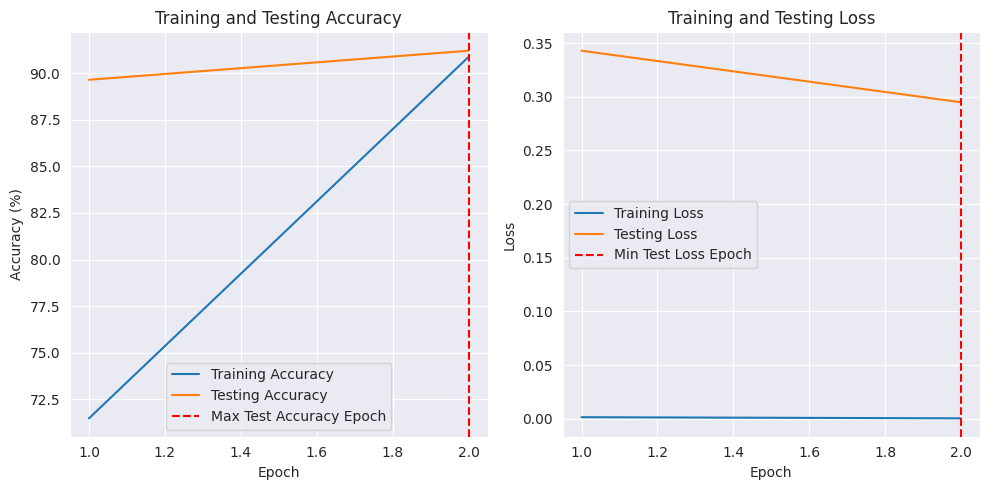

In [30]:
# Example usage:
args = {
    'lr': 0.1,
    'momentum': 0.9,
    'cuda': device.type,
    'epochs': 2,
    'log_interval': 10 # para los prints
}

model_nn = RedNeuronal(in_n=784, hidden_n=256, out_n=10)
train_and_evaluate(model_nn, train_loader, test_loader, args)

Intentemos entrenar la red que ya tenemos, con un learning rate muy grande.
Esperariamos que nuestras predicciones se comportaran como pendulo, pues un learning rate grande tiende al sobre ajuste.

**Learning Rate grande**

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.386962
Train Epoch: 1 [10000/60000 (17%)]	Loss: 146121.437500
Train Epoch: 1 [20000/60000 (33%)]	Loss: 70394.859375
Train Epoch: 1 [30000/60000 (50%)]	Loss: 30244.035156
Train Epoch: 1 [40000/60000 (67%)]	Loss: 15095.690430
Train Epoch: 1 [50000/60000 (83%)]	Loss: 8713.253906

Epoch: 1 - Train Loss: 57.046675, Train Accuracy: 35.35%, Test Loss: 4991.191000, Test Accuracy: 63.04%

Train Epoch: 2 [0/60000 (0%)]	Loss: 5094.083496
Train Epoch: 2 [10000/60000 (17%)]	Loss: 4707.809082
Train Epoch: 2 [20000/60000 (33%)]	Loss: 4824.327148
Train Epoch: 2 [30000/60000 (50%)]	Loss: 3543.009033
Train Epoch: 2 [40000/60000 (67%)]	Loss: 4466.139648
Train Epoch: 2 [50000/60000 (83%)]	Loss: 9660.647461

Epoch: 2 - Train Loss: 5.329129, Train Accuracy: 58.30%, Test Loss: 6681.343350, Test Accuracy: 54.09%



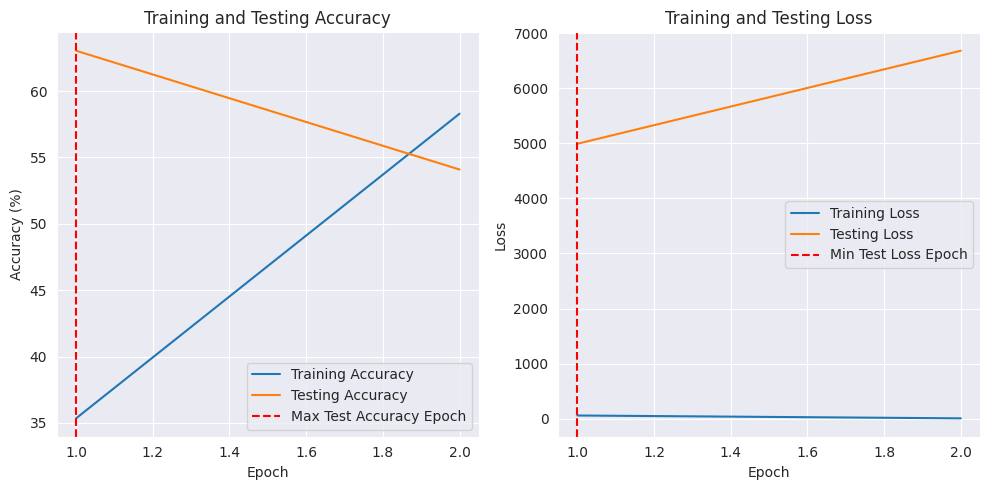

In [31]:
# Hyperparametros de Entrenamiento
# Epoca:= El numero de veces por el que pasamos por todos los datos
args['epoch'] = 5  
# La tasa de aprendizaje del descenso por gradiente 
args['lr'] = 1000


model_nn = RedNeuronal(in_n=784, hidden_n=256, out_n=10)
train_and_evaluate(model_nn, train_loader, test_loader, args)


**Learning rate Pequeno**

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.394274
Train Epoch: 1 [10000/60000 (17%)]	Loss: 2.233053
Train Epoch: 1 [20000/60000 (33%)]	Loss: 2.109603
Train Epoch: 1 [30000/60000 (50%)]	Loss: 2.003888
Train Epoch: 1 [40000/60000 (67%)]	Loss: 1.906290
Train Epoch: 1 [50000/60000 (83%)]	Loss: 1.823436

Epoch: 1 - Train Loss: 0.002031, Train Accuracy: 52.93%, Test Loss: 1.729344, Test Accuracy: 75.63%

Train Epoch: 2 [0/60000 (0%)]	Loss: 1.735088
Train Epoch: 2 [10000/60000 (17%)]	Loss: 1.662683
Train Epoch: 2 [20000/60000 (33%)]	Loss: 1.580852
Train Epoch: 2 [30000/60000 (50%)]	Loss: 1.488791
Train Epoch: 2 [40000/60000 (67%)]	Loss: 1.458246
Train Epoch: 2 [50000/60000 (83%)]	Loss: 1.396227

Epoch: 2 - Train Loss: 0.001522, Train Accuracy: 77.25%, Test Loss: 1.309179, Test Accuracy: 81.19%



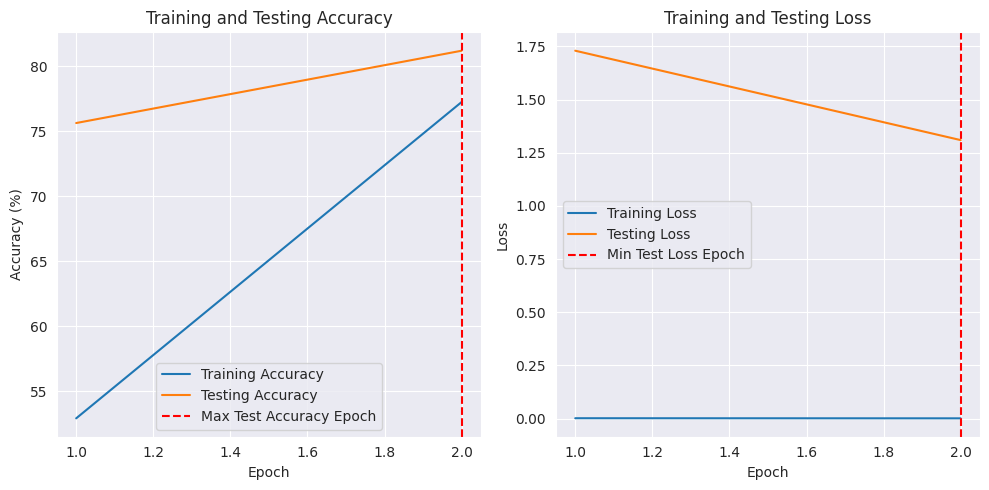

In [32]:
# Hyperparametros de Entrenamiento
# Epoca:= El numero de veces por el que pasamos por todos los datos
args['epoch']=5  
# La tasa de aprendizaje del descenso por gradiente 
args['lr']=0.0001


model_nn = RedNeuronal(in_n=784, hidden_n=256, out_n=10)
train_and_evaluate(model_nn, train_loader, test_loader, args)


**En general** Queremos que nuestro learning rate, se encuentre entre 0.0 y 1.0.  
+ Existe una compensacion inversa entre el learning rate, y el numero de epocas. Si tuvieramos tiempo y recuros, lo ideal seria tener un learning rate bajo y entrenar por muchas epocas.
+ Tambien es conventiente intentar varios learning rates, con pocas epocas para detectar optimos locales, o en su defecto empezar con diferentes pesos iniciales, como en nuestro caso.

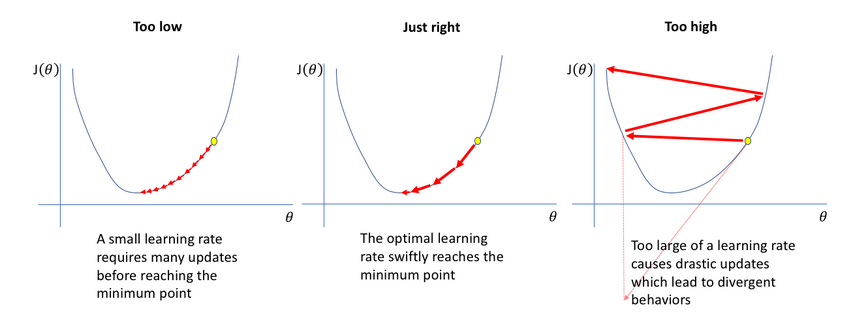

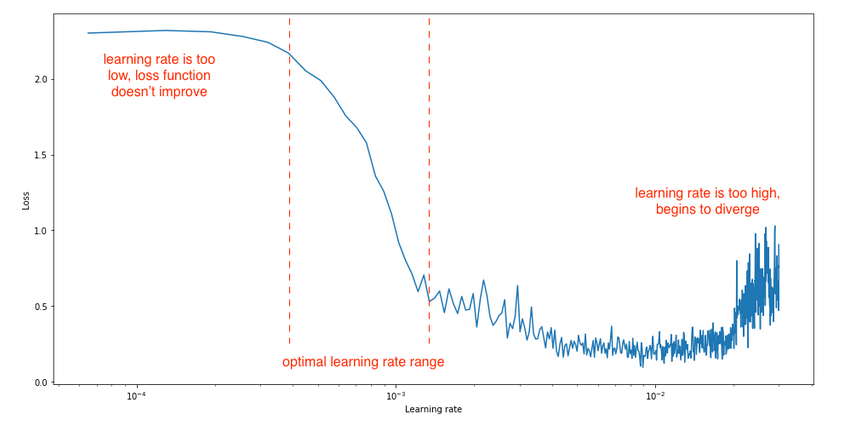

Fuente: https://www.kaggle.com/residentmario/tuning-your-learning-rate

### Entrenemos con Pocas Neuronas

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.369417
Train Epoch: 1 [10000/60000 (17%)]	Loss: 1.808473
Train Epoch: 1 [20000/60000 (33%)]	Loss: 1.567250
Train Epoch: 1 [30000/60000 (50%)]	Loss: 1.333892
Train Epoch: 1 [40000/60000 (67%)]	Loss: 1.133977
Train Epoch: 1 [50000/60000 (83%)]	Loss: 1.004875

Epoch: 1 - Train Loss: 0.001413, Train Accuracy: 69.38%, Test Loss: 0.862835, Test Accuracy: 82.69%

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.882050
Train Epoch: 2 [10000/60000 (17%)]	Loss: 0.772919
Train Epoch: 2 [20000/60000 (33%)]	Loss: 0.693313
Train Epoch: 2 [30000/60000 (50%)]	Loss: 0.648869
Train Epoch: 2 [40000/60000 (67%)]	Loss: 0.621703
Train Epoch: 2 [50000/60000 (83%)]	Loss: 0.565298

Epoch: 2 - Train Loss: 0.000663, Train Accuracy: 85.93%, Test Loss: 0.523689, Test Accuracy: 88.22%



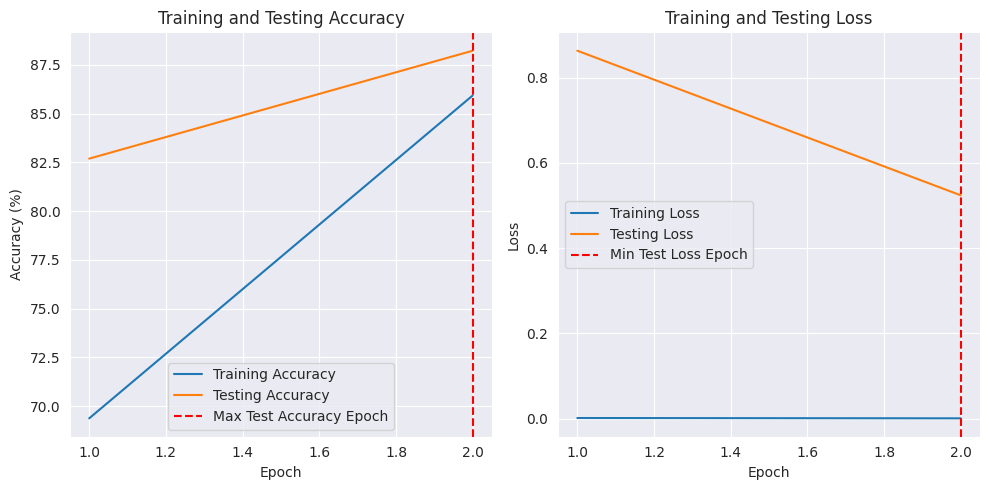

In [33]:
# Hyperparametros de Entrenamiento
# Epoca:= El numero de veces por el que pasamos por todos los datos
args['epoch']=5  
# La tasa de aprendizaje del descenso por gradiente 
args['lr']=.01


model_nn = RedNeuronal(in_n=784, hidden_n=10, out_n=10)
train_and_evaluate(model_nn, train_loader, test_loader, args)

### Entrenemos con mas neuronas

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.345425
Train Epoch: 1 [10000/60000 (17%)]	Loss: 0.888398
Train Epoch: 1 [20000/60000 (33%)]	Loss: 0.396372
Train Epoch: 1 [30000/60000 (50%)]	Loss: 0.336898
Train Epoch: 1 [40000/60000 (67%)]	Loss: 0.260936
Train Epoch: 1 [50000/60000 (83%)]	Loss: 0.195336

Epoch: 1 - Train Loss: 0.000622, Train Accuracy: 82.03%, Test Loss: 0.179337, Test Accuracy: 94.49%

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.195667
Train Epoch: 2 [10000/60000 (17%)]	Loss: 0.150090
Train Epoch: 2 [20000/60000 (33%)]	Loss: 0.163309
Train Epoch: 2 [30000/60000 (50%)]	Loss: 0.165905
Train Epoch: 2 [40000/60000 (67%)]	Loss: 0.167316
Train Epoch: 2 [50000/60000 (83%)]	Loss: 0.107838

Epoch: 2 - Train Loss: 0.000146, Train Accuracy: 95.65%, Test Loss: 0.122391, Test Accuracy: 96.27%



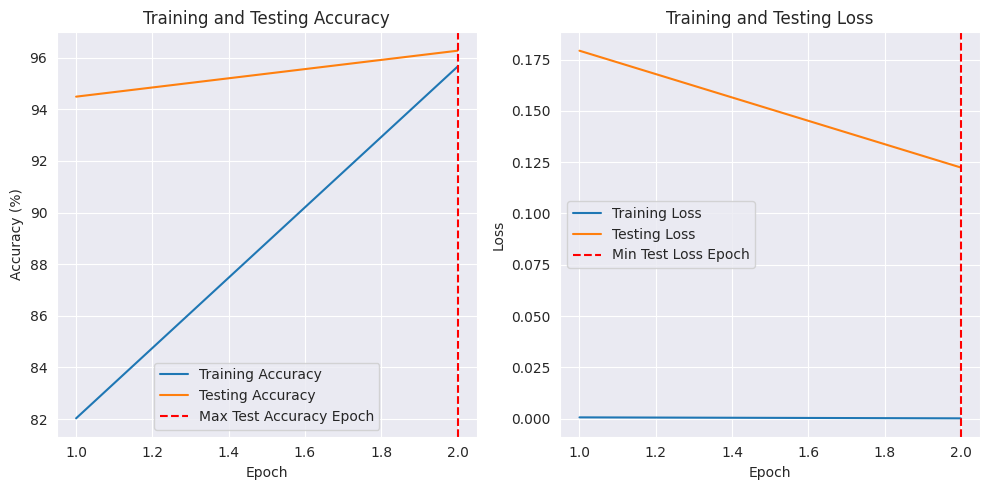

In [34]:
# Hyperparametros de Entrenamiento
# Epoca:= El numero de veces por el que pasamos por todos los datos
args['epoch']=5  
# La tasa de aprendizaje del descenso por gradiente 
args['lr']=.01


model_nn = RedNeuronal(in_n=784, hidden_n=1000, out_n=10)
train_and_evaluate(model_nn, train_loader, test_loader, args)

### Entrenemos con aun mas neuronas

In [ ]:
# Hyperparametros de Entrenamiento
# Epoca:= El numero de veces por el que pasamos por todos los datos
args['epoch']=5  
# La tasa de aprendizaje del descenso por gradiente 
args['lr']=.01


model_nn = RedNeuronal(in_n=784, hidden_n=784, out_n=10)
train_and_evaluate(model_nn, train_loader, test_loader, args)

### Entrenemos con muchas Neuronas

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.340783
Train Epoch: 1 [10000/60000 (17%)]	Loss: 1.552945
Train Epoch: 1 [20000/60000 (33%)]	Loss: 0.998811
Train Epoch: 1 [30000/60000 (50%)]	Loss: 0.587631
Train Epoch: 1 [40000/60000 (67%)]	Loss: 0.427158
Train Epoch: 1 [50000/60000 (83%)]	Loss: 0.363236

Epoch: 1 - Train Loss: 0.001520, Train Accuracy: 71.20%, Test Loss: 0.235639, Test Accuracy: 93.16%

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.210201
Train Epoch: 2 [10000/60000 (17%)]	Loss: 0.203810
Train Epoch: 2 [20000/60000 (33%)]	Loss: 0.190419
Train Epoch: 2 [30000/60000 (50%)]	Loss: 0.178757
Train Epoch: 2 [40000/60000 (67%)]	Loss: 0.158687
Train Epoch: 2 [50000/60000 (83%)]	Loss: 0.163676

Epoch: 2 - Train Loss: 0.000177, Train Accuracy: 94.87%, Test Loss: 0.139321, Test Accuracy: 95.92%



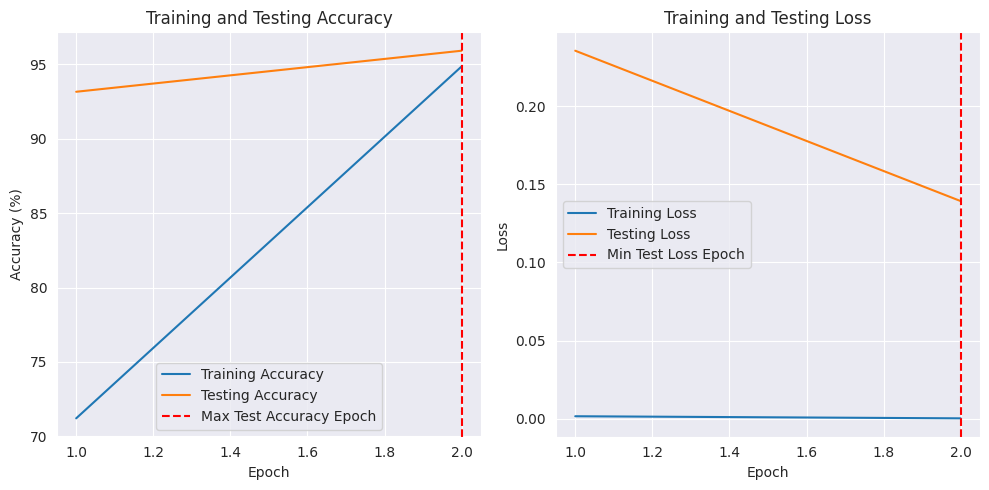

In [36]:
# Hyperparametros de Entrenamiento
# Epoca:= El numero de veces por el que pasamos por todos los datos
args['epoch']=5  
# La tasa de aprendizaje del descenso por gradiente 
args['lr']=.01


model_nn = RedNeuronal(in_n=784, hidden_n=5000, out_n=10)
train_and_evaluate(model_nn, train_loader, test_loader, args)


### Entrenemos con un Batch Size diferente

In [54]:
# Hyperparametros de Entrenamiento
# Epoca:= El numero de veces por el que pasamos por todos los datos
args['epoch']=5  
# La tasa de aprendizaje del descenso por gradiente 
args['lr']=.01


train_loader = torch.utils.data.DataLoader(
    datasets.MNIST(root='../data', 
                   train=True, 
                   download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=1, 
    shuffle=True)


model_nn = RedNeuronal(in_n=784, hidden_n=256, out_n=10)
train_and_evaluate(model_nn, train_loader, test_loader, args)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.934712
Train Epoch: 1 [10/60000 (0%)]	Loss: 2.111616
Train Epoch: 1 [20/60000 (0%)]	Loss: 4.503801
Train Epoch: 1 [30/60000 (0%)]	Loss: 1.791421
Train Epoch: 1 [40/60000 (0%)]	Loss: 3.166097
Train Epoch: 1 [50/60000 (0%)]	Loss: 2.218890
Train Epoch: 1 [60/60000 (0%)]	Loss: 3.192616
Train Epoch: 1 [70/60000 (0%)]	Loss: 2.244223
Train Epoch: 1 [80/60000 (0%)]	Loss: 0.035940
Train Epoch: 1 [90/60000 (0%)]	Loss: 1.968709
Train Epoch: 1 [100/60000 (0%)]	Loss: 2.496805
Train Epoch: 1 [110/60000 (0%)]	Loss: 1.099682
Train Epoch: 1 [120/60000 (0%)]	Loss: 2.550947
Train Epoch: 1 [130/60000 (0%)]	Loss: 1.773664
Train Epoch: 1 [140/60000 (0%)]	Loss: 0.777094
Train Epoch: 1 [150/60000 (0%)]	Loss: 1.794126
Train Epoch: 1 [160/60000 (0%)]	Loss: 1.266205
Train Epoch: 1 [170/60000 (0%)]	Loss: 1.255808
Train Epoch: 1 [180/60000 (0%)]	Loss: 2.175815
Train Epoch: 1 [190/60000 (0%)]	Loss: 2.191382
Train Epoch: 1 [200/60000 (0%)]	Loss: 1.287772
Train Epoch: 1 [210/6000